In [10]:
import numpy as np
import matplotlib.pyplot as plt
import glob as g
import pandas as pd

In [11]:
SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.style.use('seaborn-v0_8')

In [12]:
file = sorted(g.glob('output_rrtm_MLS-clr*'))
print(file)

finput = sorted(g.glob('input_rrtm_MLS-clr*'))
print(finput)

['output_rrtm_MLS-clr', 'output_rrtm_MLS-clr-CO2', 'output_rrtm_MLS-clr-H2O', 'output_rrtm_MLS-clr-O3', 'output_rrtm_MLS-clr-aer12', 'output_rrtm_MLS-clr-sza45-isolvar0_tsi_avg', 'output_rrtm_MLS-clr-sza45-isolvar1_tsi_max', 'output_rrtm_MLS-clr-sza45-isolvar1_tsi_min', 'output_rrtm_MLS-clr-sza45-isolvar2_01Jan1950', 'output_rrtm_MLS-clr-sza45-isolvar3_bndscl_tsi_max', 'output_rrtm_MLS-clr-sza65']
['input_rrtm_MLS-clr', 'input_rrtm_MLS-clr-aer12', 'input_rrtm_MLS-clr-sza45-isolvar0_tsi_avg', 'input_rrtm_MLS-clr-sza45-isolvar1_tsi_max', 'input_rrtm_MLS-clr-sza45-isolvar1_tsi_min', 'input_rrtm_MLS-clr-sza45-isolvar2_01Jan1950', 'input_rrtm_MLS-clr-sza45-isolvar3_bndscl_tsi_max', 'input_rrtm_MLS-clr-sza65']


In [17]:
#This is for custom reading - for input files
# Output yields layer-wise pressure and temperature

def rrtmg_sw_input_read(nlev, file):
    temparr = np.empty(0);
    parr = np.empty(0);
    tave = np.empty(0);
    pave = np.empty(0);
    mix_ratio = np.array([[0.0 for x in range(8)]for y in range(51)]);
    
    fi = open(finput[0], 'r')
    lines = fi.readlines()[0:]

    line8 = lines[8].split()
    #Updating pressure and temperature for top and bottom of 1st layer separately
    temparr = np.append(temparr, line8[5])
    parr = np.append(parr, line8[4])
    temparr = np.append(temparr, line8[8])
    parr = np.append(parr, line8[7])
    tave = np.append(tave, line8[1]);
    pave = np.append(pave, line8[0]);    

    for j in range(10,nlev,2):
       tmp1 = lines[j];
       tmpave = tmp1.split();
       tave = np.append(tave, tmpave[1]);
       pave = np.append(pave, tmpave[0]);
       indices = [71];
       tmp2 = [tmp1[i:j] for i,j in zip(indices, indices[1:]+[None])];
       tmp3 = np.empty([0,0])
       for val in tmp2:
        tmp3 = np.append(tmp3, val.split())
       temparr = np.append(temparr, tmp3[1])
       parr = np.append(parr, tmp3[0])

    for j in range(9, nlev, 2):
       tmp1 = lines[j]
       tmp2 = tmp1.split()
       for u in range(0,len(tmp2)):
           tmp2[u] = float(tmp2[u])
       # print(tmp2)
       for k in range(0,len(tmp2)):
         mix_ratio[(j-8)//2][k] = tmp2[k]
        
    temparr = [float(val) for val in temparr]
    parr = [float(value) for value in parr]
    tave = [float(val) for val in tave]
    pave = [float(value) for value in pave]    
    fi.close()

    return temparr, parr, tave, pave, mix_ratio

In [37]:
#This is for custom reading - for outputs that are partitioned into data based on wavenumber bands.
# A search with a certain wavenumber string would yield a relevant output

def rrtmg_sw_output_read(nlev, file, string):
    lvl = np.full(nlev,np.nan);
    prs = np.full(nlev,np.nan);
    fup = np.full(nlev,np.nan);
    fdn = np.full(nlev,np.nan);
    fnt = np.full(nlev,np.nan);
    htr = np.full(nlev,np.nan);
    
    fi  = open(file,'r')
    lines = fi.readlines()[0:]
    for row in lines:
        # check if string present on a current line
        word = string
        # if found it returns index of the first occurrence of the substring
        if row.find(word) != -1:
            print('string exists in file')
            index = lines.index(row)
            #print(index)
            lines = lines[index+3:]
            break
    
    #print(lines)

    for j in range(0,nlev):

        tmp1 = lines[j];
        tmp2 = tmp1.split();
        lvl[j] = tmp2[0];
        prs[j] = tmp2[1];
        fup[j] = tmp2[2];
        fdn[j] = tmp2[5];
        fnt[j] = tmp2[6];
        htr[j] = tmp2[7]; 
        
    lvl = lvl[::-1]
    prs = prs[::-1]
    fup = fup[::-1]
    fdn = fdn[::-1]
    fnt = fnt[::-1]
    htr = htr[::-1]
    
    fi.close()
    return lvl,prs,fnt,htr,string,fup,fdn


Define an array for all strings:
```
bands = np.array(['820. -  2600.', '2600. -  3250.', '3250. -  4000.', '4000. -  4650.', '4650. -  5150.','5150. -  6150.', '6150. -  7700.', '7700. -  8050.', '8050. - 12850.', '12850. - 16000.', '16000. - 22650.',  '22650. - 29000.', '29000. - 38000.', '38000. - 50000.', '820. - 50000.'])
```

In [38]:
def return_bands():
    bands = np.array(['820. -  2600.', '2600. -  3250.', '3250. -  4000.', '4000. -  4650.', '4650. -  5150.','5150. -  6150.', '6150. -  7700.', '7700. -  8050.', '8050. - 12850.', '12850. - 16000.', '16000. - 22650.',  '22650. - 29000.', '29000. - 38000.', '38000. - 50000.', '820. - 50000.'])
    return bands

In [39]:
input_mls = rrtmg_sw_input_read(110, finput[0])
output_mls = rrtmg_sw_output_read(51,file[0],return_bands()[14]) #Midlattitude summer sky, clear conditions, 51 layers

string exists in file


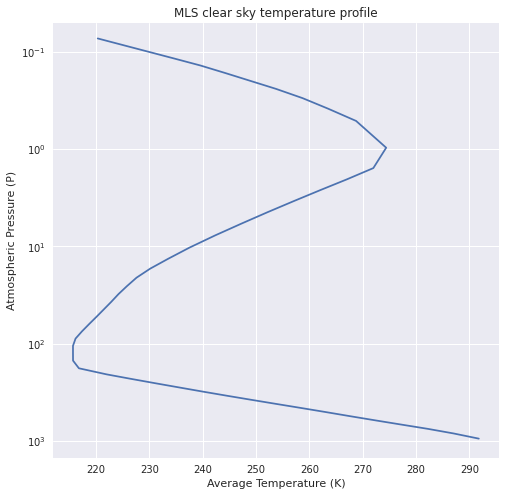

In [40]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(input_mls[2], input_mls[3])
ax.set_xlabel('Average Temperature (K)')
ax.set_ylabel('Atmospheric Pressure (P)')
ax.set_yscale('log')
ax.set_ylim(1500,0.05)
ax.set_title('MLS clear sky temperature profile')
plt.savefig('MLS Temp.pdf', bbox_inches='tight')

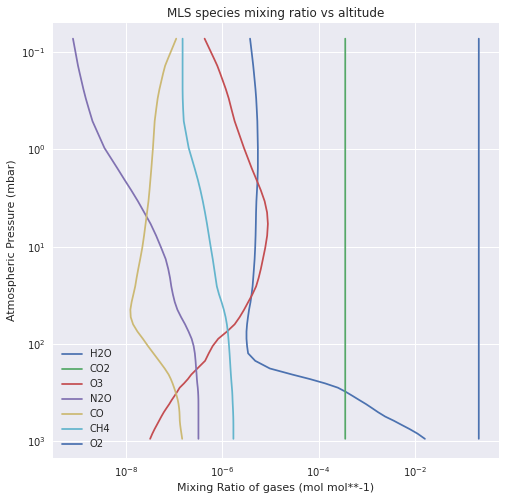

In [41]:
fig, ax = plt.subplots(figsize=(8,8))
for k in range(0,7):
    ax.plot(input_mls[4][:,k], input_mls[3])
ax.set_xlabel('Mixing Ratio of gases (mol mol**-1)')
ax.set_ylabel('Atmospheric Pressure (mbar)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1500,0.05)
ax.set_title('MLS species mixing ratio vs altitude')
ax.legend(['H2O','CO2','O3','N2O','CO','CH4','O2'])
plt.savefig('mix-ratio.pdf', bbox_inches='tight')

Text(0.5, 1.0, 'MLS clear sky heating rate')

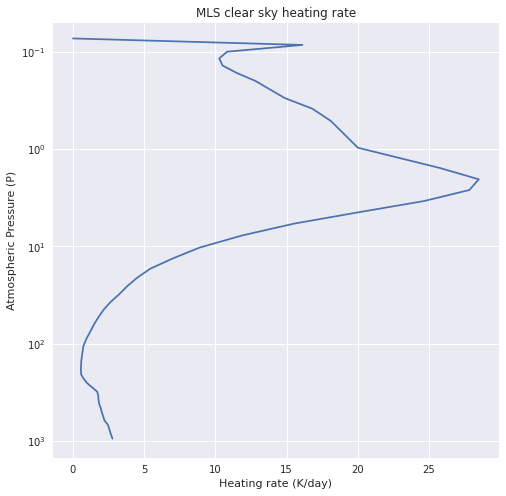

In [42]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(output_mls[3], input_mls[3])
ax.set_xlabel('Heating rate (K/day)')
ax.set_ylabel('Atmospheric Pressure (P)')
ax.set_yscale('log')
ax.set_ylim(1500,0.05)
ax.set_title('MLS clear sky heating rate')